## Style Transfer


### Install packages

In [146]:
# Install part
!pip install torch torchvision matplotlib tqdm numpy



### Import packages

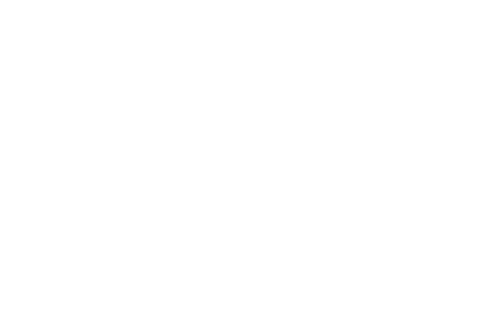

In [147]:
## Import stuffs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
plt.axis('off')
plt.ion()
import numpy as np
from tqdm import tqdm
import pdb

from PIL import Image
import io
import copy
from google.colab import files
from pathlib import Path

import torchvision.models as models

from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

### Loss function definition

In [0]:
#### Content loss functions
class ContentLoss(nn.Module):
  def __init__(self, input=None, target=None, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(ContentLoss, self).__init__()
    self.__dict__.update(locals())

  def forward(self, input, target):
    # Input is the generated image and target is content image
    loss = torch.tensor([0.0]).cuda()
    # Compute loss for each layer. Based on the paper its a weighted sum 0.2 per
    # layer
    for key in target.keys():
      #loss += 0.2 * F.mse_loss(input[key], target[key])
      # Multiplying loss by 0.2 hinders the learning process and is very slow
      loss += F.mse_loss(input[key], target[key])
    return loss

#### Style loss function
class StyleLoss(nn.Module):
  def __init__(self, input=None, target=None, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(StyleLoss, self).__init__()
    self.__dict__.update(locals())

  
  def gram(self, layer):
    a,b,c,d = layer.size()
    resized = layer.view(a*b, c*d)
    return torch.mm(resized, resized.t()) / (a*b*c*d)
    
  def forward(self, input, target):
    loss = torch.tensor([0.0]).cuda()
    # Compute gram matrix and use it to find loss. Similar to content loss
    # total loss is the weighted sum of 0.2 per layer
    for key in target.keys():
      gram_generated = self.gram(input[key])
      gram_original = self.gram(target[key])
      #loss += 0.2 * F.mse_loss(gram_generated, gram_original)
      # Multiplying loss by 0.2 hinders the learning process and is very slow
      loss += F.mse_loss(gram_generated, gram_original)
    
    return loss
    

### VGG Network

In [0]:
class VGGI(nn.Module):
  def __init__(self, requested=[]):
    super(VGGI, self).__init__()
    
    mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).cuda()
    
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
    
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval().cuda()
    
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        # print (type(m).__name__)  
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    # Normlization
    x = (x - self.mean) / self.std
    
    self.vgg(x)
    return self.intermediates  

### Plot Loss

In [0]:
def plotloss(loss):
  plt.figure()
  x = range(len(loss))
  plt.plot(x, loss, label='Training loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Losses per Epoch")
  plt.legend()
  plt.show()  

### Draw the image

In [0]:
def drawimage(img, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    plt.axis('off')
    image = img.cpu().clone()  
    image = image.squeeze(0)      
    unloader = transforms.ToPILImage()
    image = unloader(image)
    ax1.grid(False)
    plt.title(title)
    plt.imshow(image)
    plt.pause(0.001)

### Load the images

In [0]:
load = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor()
])

  
def load_images(content='content.png', style='style.png'):  
  
  filename = content
  if Path(filename).exists():
    cimage = Image.open(filename)
  else:
    print('Upload Content Image')
    file_dict = files.upload()
    cimage = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
  
  content_image = load(np.array(cimage)).unsqueeze(0)
  #drawimage(content_image)
  
  filename = style
  if Path(filename).exists():
    simage = Image.open(filename)
  else:
    print('\nUpload Style Image')
    file_dict = files.upload()
    simage = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
  
  style_image = load(np.array(simage)).unsqueeze(0)
  
  generated_image = copy.deepcopy(content_image)
  #nn.init.kaiming_uniform_(generated_image, mode='fan_in', nonlinearity='relu')
  
  return content_image, style_image, generated_image
  

### Style transfer block

In [0]:
# Load the VGG network
## VGG network for content image
cvgg16 = VGGI([24])     # conv4_1 and conv5_1
## VGG network for generated image    # conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1
gvgg16 = VGGI([5, 10, 17, 24, 31])
## VGG network for style iamge
svgg16 = VGGI([5, 10, 17, 24, 31])     # conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1

def transfer_style(epochs, content='content.png', style='style.png', alpha=0.000000001, beta=100000):
  # Losses
  content_loss = ContentLoss()
  style_loss = StyleLoss()

  # Weight factor for losses
  # From function argument

  # Load the images
  content_image, style_image, generated_image = load_images(content, style)

  # Define optimizer
  optimizer = optim.LBFGS([generated_image.requires_grad_()])

  # Progress loop
  # epochs = iter
  loop = tqdm(total=1*epochs, position=0)

  # Total loss list
  total_loss = []

  # Run optimization for epoch
  for epoch in range(epochs):
    def innerfunc():
      # Clamp the pixel in the image
      generated_image.data.clamp_(0, 1)
      #generated_image = torch.sigmoid(generated_image)

      # Reset the grad
      optimizer.zero_grad()

      # Move forward the network and compute the neurons activations
      style_layers = svgg16(style_image.cuda()) 
      content_layers = cvgg16(content_image.cuda())
      generated_layers = gvgg16(generated_image.cuda())

      # Compute loss
      lossc = content_loss(generated_layers, content_layers)
      losss = style_loss(generated_layers, style_layers)

      # compute total loss and Backpropagate it
      loss = alpha * lossc + beta * losss
      loss.backward()

      # Update the progress bar
      loop.set_description(
        'epoch:{}, loss:{:.4f}, closs:{:.4f}, sloss:{:.4f}'.format(
            epoch, loss.item(), lossc.item(), losss.item()))  

      total_loss.append(loss)
      return loss

    loop.update(1)

    # Optimize
    optimizer.step(innerfunc)
    
  
  return content_image, style_image, generated_image
  



## First style transfer experiment

epoch:9, loss:212299.7188, closs:6629340.5000, sloss:14.6006: 100%|██████████| 10/10 [00:52<00:00,  5.33s/it]

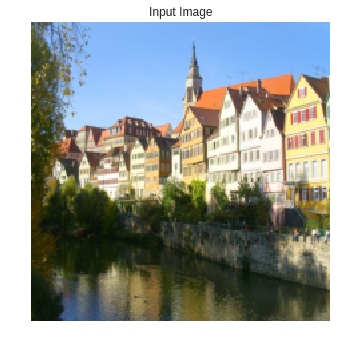

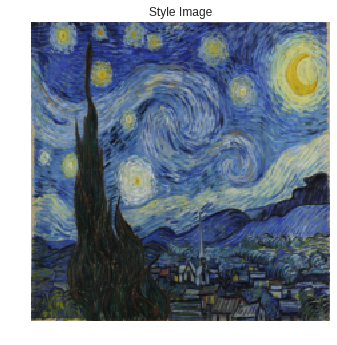

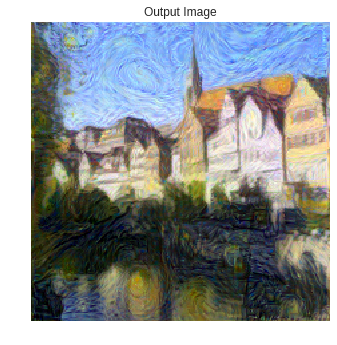

In [154]:
content_image, style_image, generated_image = transfer_style(10, content='content.png', style='style.png', alpha=0.01, beta=10000)

drawimage(content_image, "Input Image")  
drawimage(style_image, "Style Image") 
drawimage(generated_image, "Output Image")  

## Second Style Transfer

epoch:9, loss:296226.7812, closs:7020970.0000, sloss:22.6017: 100%|██████████| 10/10 [00:52<00:00,  5.34s/it]

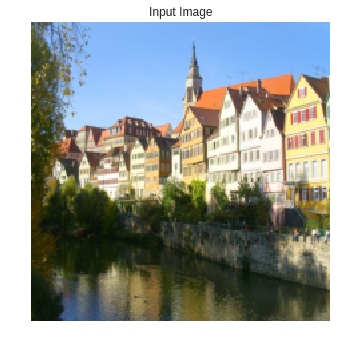

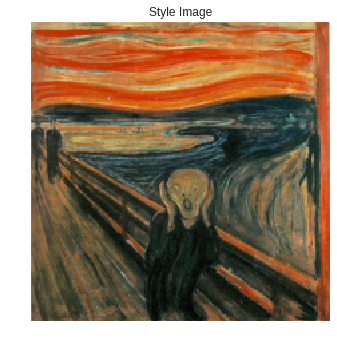

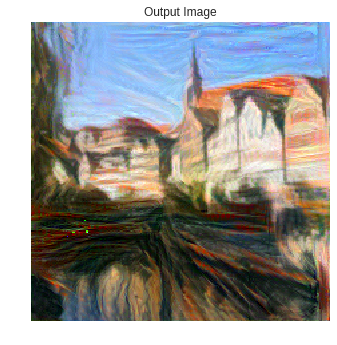

In [155]:
content_image, style_image, generated_image = transfer_style(10, content='content.png', style='style2.png', alpha=0.01, beta=10000)

drawimage(content_image, "Input Image")  
drawimage(style_image, "Style Image") 
drawimage(generated_image, "Output Image")  

## Third Style Transfer

epoch:9, loss:218809.6562, closs:5065543.0000, sloss:16.8154: 100%|██████████| 10/10 [00:52<00:00,  5.38s/it]

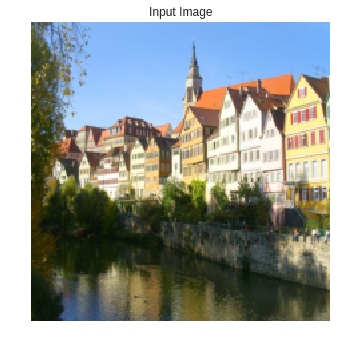

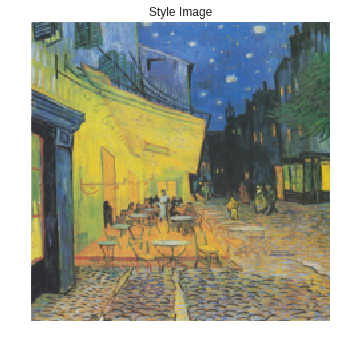

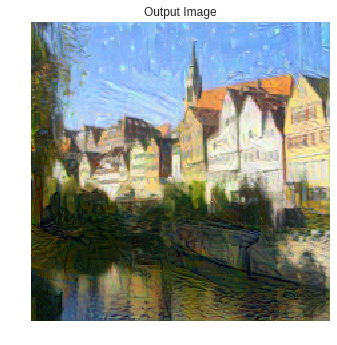

In [156]:
content_image, style_image, generated_image = transfer_style(10, content='content.png', style='style3.png', alpha=0.01, beta=10000)

drawimage(content_image, "Input Image")  
drawimage(style_image, "Style Image") 
drawimage(generated_image, "Output Image")  

## Fourth style transfer

epoch:9, loss:751401.0000, closs:7359166.0000, sloss:67.7809: 100%|██████████| 10/10 [00:52<00:00,  5.39s/it]

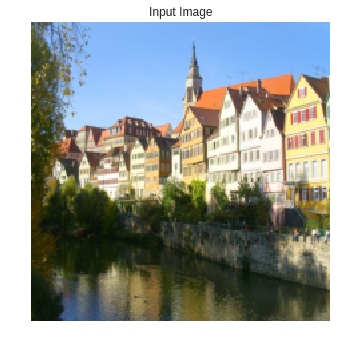

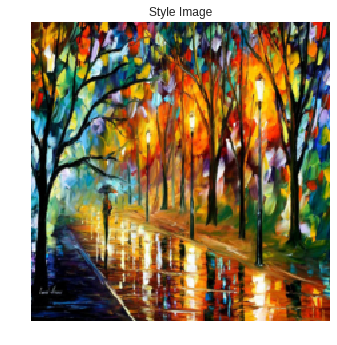

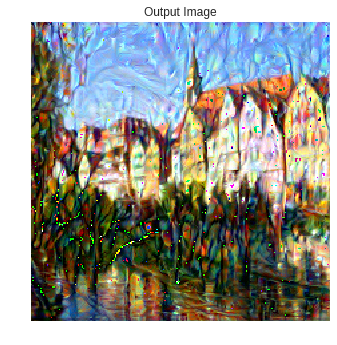

In [157]:
content_image, style_image, generated_image = transfer_style(10, content='content.png', style='style4.png', alpha=0.01, beta=10000)

drawimage(content_image, "Input Image")  
drawimage(style_image, "Style Image") 
drawimage(generated_image, "Output Image")  

## Fifth Style transfer


Upload Style Image


Saving style3.png to style3 (2).png


epoch:9, loss:552049.5625, closs:8621059.0000, sloss:46.5839: 100%|██████████| 10/10 [00:52<00:00,  5.37s/it]

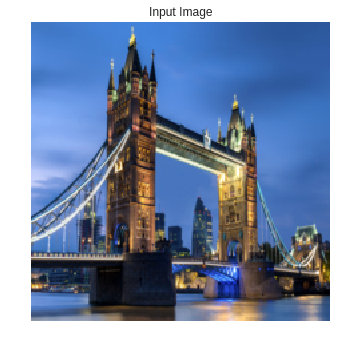

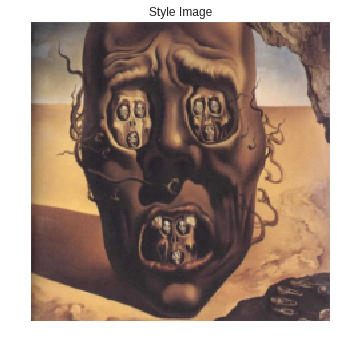

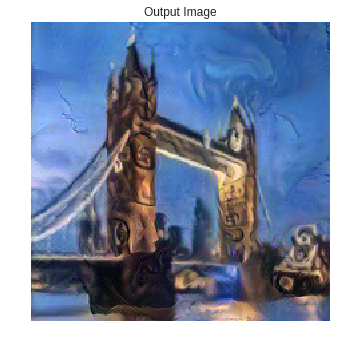

In [160]:
content_image, style_image, generated_image = transfer_style(10, content='content1.png', style='style6.png', alpha=0.01, beta=10000)

drawimage(content_image, "Input Image")  
drawimage(style_image, "Style Image") 
drawimage(generated_image, "Output Image")  